In [2]:
import torch
from matplotlib import pyplot as plt
from torch.optim import Adam
from gpytorch.optim import NGD

from alfi.models import generate_multioutput_gp
from alfi.plot import Plotter1d
from alfi.utilities.torch import softplus
from alfi.datasets import SingleCellKidney, Pancreas
from alfi.impl.trainers import EMTrainer
from alfi.impl.odes import RNAVelocityLFM, RNAVelocityConfiguration

import numpy as np

In [3]:
# kidney_path = '/Volumes/ultra/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
# kidney_path = 'F:/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
#
# dataset = SingleCellKidney(calc_moments=True, raw_data_dir=kidney_path)
single_gene = True
cpe_index = 1710

if single_gene:
    dataset = Pancreas(data_dir='../../data', gene_index=cpe_index)
    cpe_index = 0
else:
    dataset = Pancreas(data_dir='../../data')
# cpe_index = np.where(dataset.loom.var.index == 'Cpe')[0][0]
num_cells = dataset[0].shape[1]
num_genes = 1 if single_gene else 2000
num_outputs = 2 * num_genes
num_latents = 1 if single_gene else 10
num_inducing = 20  # (I x m x 1)
num_timepoint_choices = 200
end_t = 20

In [4]:
data = dataset.m_observed.squeeze().clone()
y_target = data
u_y = y_target[:num_genes]  # (num_genes, num_cells)
s_y = y_target[num_genes:]  # (num_genes, num_cells)
# w = torch.logical_and(u_y > 0, s_y > 0)
# u_y = torch.gather(u_y, dim=1, index=w)
u_norm = u_y / u_y.max(dim=1).values.unsqueeze(1)
s_norm = s_y / s_y.max(dim=1).values.unsqueeze(1)
norm = u_norm + s_norm
weights = norm >= torch.tensor(np.percentile(norm, 95, axis=1)).unsqueeze(1)

s = s_y * weights
u = u_y * weights
s = s.unsqueeze(-1)
u = u.unsqueeze(1)

gamma = torch.matmul(u, s).squeeze(1).squeeze(1)
l2 = s.squeeze(2).square().sum(dim=1)
gamma /= l2
gamma = gamma.unsqueeze(-1)
if single_gene:
    gamma += 0
    print(gamma)
print(gamma.shape, gamma.max(), gamma.min(), gamma[cpe_index])

tensor([[0.1141]])
torch.Size([1, 1]) tensor(0.1141) tensor(0.1141) tensor([0.1141])


In [5]:
beta = 1.
u_infty = torch.ones_like(gamma)
s_infty = 1./gamma
beta_tilde = beta / (gamma - beta)
print(u_y.shape)
s_tilde = s_y - beta_tilde * u_y
s_tilde_infty = s_infty - beta_tilde * u_infty
print(s_infty, u_infty, s_tilde_infty, s_tilde)
t = -1/gamma * torch.log((s_tilde - s_tilde_infty) / (-s_tilde_infty))
time_ass = t.nan_to_num(0)
print(t)

splicing_rate = torch.zeros_like(gamma)
splicing_rate += 2.013
transcription_rate = torch.zeros_like(gamma)
transcription_rate += 2.96#3.6
gamma = torch.zeros_like(gamma)
gamma += 0.189


torch.Size([1, 3696])
tensor([[8.7662]]) tensor([[1.]]) tensor([[9.8950]]) tensor([[12.4695,  0.0596, 14.6405,  ...,  0.0818, 14.1306, 11.9084]])
tensor([[   nan, 0.0530,    nan,  ..., 0.0728,    nan,    nan]])


In [6]:
def print_scatter(cells, gene_index,
                  num_connections=10,
                  figsize=(3, 3),
                  colors=None,
                  time_ass=None):
    traj = lfm.current_trajectory
    u = traj[:num_genes].detach()  # (num_genes, 100)
    s = traj[num_genes:].detach()  # (num_genes, 100)
    u_y = cells[:num_genes]  # (num_genes, num_cells)
    s_y = cells[num_genes:]  # (num_genes, num_cells)
    print(u.shape)
    plt.figure(figsize=figsize)
    plt.title(dataset.gene_names[gene_index])

    # Plot trajectory
    plt.plot(s[gene_index], u[gene_index], color='red')

    # Plot cell points
    indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                             u_y[gene_index, :, 0].nonzero())
    if time_ass is None:
        time_ass = 'black'
    else:
        time_ass = time_ass[0, indices] / time_ass[0, indices].max()
    plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0],
                alpha=0.1, s=5, cmap='viridis', c=time_ass)

    # Plot timepoint choices
    for timepoint in range(lfm.timepoint_choices.shape[0]):
        plt.scatter(s[gene_index, timepoint], u[gene_index, timepoint], s=4, c='black')

    # Plot some connections between cell points and the trajectory line
    for i in range(num_connections):
        plt.scatter(s_y[gene_index, i, 0], u_y[gene_index, i, 0], s=8, c='red')
        line = [
            (s[gene_index, lfm.time_assignments_indices[i]], s_y[gene_index, i, 0]),
            (u[gene_index, lfm.time_assignments_indices[i]], u_y[gene_index, i, 0])
        ]
        plt.plot(line[0], line[1], alpha=0.5, c='purple')
        # trainer.time_assignments_indices[i]
    plt.ylabel('unspliced')
    plt.xlabel('spliced')

In [7]:
use_natural = True
step_size = 1e-1
config = RNAVelocityConfiguration(
    latent_data_present=True,
    num_samples=30,
    num_cells=num_cells,
    end_pseudotime=end_t,
    num_timepoint_choices=num_timepoint_choices
)

print('Number of cells:', num_cells)
print('Number of latent GPs (# transcription rates):', num_latents)


inducing_points = torch.linspace(0, end_t, num_inducing).repeat(num_latents, 1).view(num_latents, num_inducing, 1)
t_predict = torch.linspace(0, end_t, 80, dtype=torch.float32)

from gpytorch.kernels import MaternKernel
gp_model = generate_multioutput_gp(num_latents, inducing_points,
                                   kernel_class=MaternKernel,
                                   kernel_kwargs=dict(nu=1.5),
                                   zero_mean=False,
                                   use_scale=False, initial_lengthscale=8,
                                   gp_kwargs=dict(natural=use_natural))


Number of cells: 3696
Number of latent GPs (# transcription rates): 1


In [8]:
data = dataset.m_observed
cells = data.permute(1, 2, 0)  # (O, C, 1)
u_y = cells[:num_genes]  # (num_genes, num_cells)
s_y = cells[num_genes:]  # (num_genes, num_cells)
nonzero_mask = list()
for gene_index in range(num_genes):
    nonzero_mask.append(torch.logical_and(s_y[gene_index, :, 0] > 0,
                                          u_y[gene_index, :, 0] > 0))
nonzero_mask = torch.stack(nonzero_mask).repeat(2, 1)
if config.latent_data_present:
    filler = torch.ones(nonzero_mask.shape[1]).unsqueeze(0)
    nonzero_mask = torch.cat([nonzero_mask, filler])

num_data = config.num_timepoint_choices
lfm_kwargs = dict(
    nonlinearity=softplus,
    decay_rate=gamma,
    splicing_rate=splicing_rate,
    transcription_rate=transcription_rate,
    num_training_points=num_data,
    nonzero_mask=nonzero_mask
)
track_parameters = [
    'raw_transcription_rate',
    'raw_splicing_rate',
    'raw_decay_rate'
]
lfm = RNAVelocityLFM(num_outputs, gp_model, config, **lfm_kwargs)

# Add latent points to the data
if config.latent_data_present:
    data = torch.stack(dataset.data)
    t = torch.linspace(0, end_t, lfm.timepoint_choices.shape[0])
    alpha = transcription_rate.item()
    y = alpha * (1 - torch.sigmoid(t * 12 / end_t - 7))#pha/2., 0., 0., 0., 0., 0.]).unsqueeze(-1)
    filler = torch.zeros(data.shape[2] - lfm.timepoint_choices.shape[0])
    y = torch.cat([y, filler], dim=0).view(1, 1, -1)
    data = torch.cat([data, y], dim=0)
    dataset.data = list(data)

if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_data, lr=0.05)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.01)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [torch.optim.Adam(lfm.parameters(), lr=0.02)]
batch_size = num_outputs + 1 if config.latent_data_present else num_outputs
trainer = EMTrainer(lfm, optimizers, dataset, batch_size=batch_size, track_parameters=track_parameters)
plotter = Plotter1d(lfm, dataset.gene_names)

torch.Size([200])
Epoch 0 loss 3.5125324726104736 l 8.0
Epoch 10 loss 1.414126992225647 l 7.907807350158691
Epoch 20 loss 1.3919663429260254 l 7.817922115325928
Epoch 30 loss 1.369157075881958 l 7.739343166351318
Epoch 40 loss 1.3430858850479126 l 7.670297145843506
Epoch 50 loss 1.3147573471069336 l 7.606322288513184
tensor([[2.0130]])
tensor([[2.9600]]) tensor([[2.9600]])
tensor([[0.1890]])
torch.Size([1, 200])


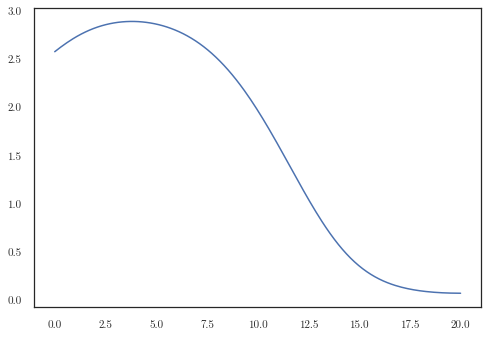

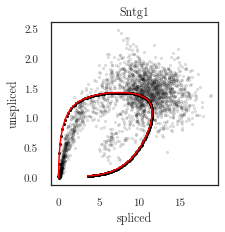

In [9]:
pretrain=True
if pretrain:
    # Training the GP model
    from gpytorch.mlls import VariationalELBO
    from gpytorch.likelihoods import MultitaskGaussianLikelihood
    from torch.optim import Adam
    from alfi.utilities.torch import inv_softplus
    like = MultitaskGaussianLikelihood(1)
    mll = VariationalELBO(like, gp_model, 50)
    if use_natural:
        optims = [
            NGD(gp_model.variational_parameters(), 50, lr=0.1),
            Adam([
                {'params':gp_model.hyperparameters()},
                {'params':like.parameters()}
                ], lr=0.01)
        ]

    else:
        optims = [Adam(gp_model.parameters(), lr=0.05)]
    t = torch.linspace(0, end_t, config.num_timepoint_choices)
    print(t.shape)
    y_train = inv_softplus(y[0, 0, :config.num_timepoint_choices]).view(-1, 1)
    # plt.plot(t, y)
    for epoch in range(60):
        [optim.zero_grad() for optim in optims]
        out = gp_model(t)
        loss = - mll(out, y_train)
        if epoch % 10 == 0:
            print('Epoch', epoch, 'loss', loss.item(), 'l', gp_model.covar_module.lengthscale.item())
        loss.backward()
        [optim.step() for optim in optims]

    out = gp_model(t)
    plt.plot(t, softplus(out.mean[:, 0].detach()))
    with torch.no_grad():
        # transcription_rate += 1.
        # lfm.raw_transcription_rate -= 3
        # lfm.raw_splicing_rate += 0.5
        print(lfm.splicing_rate)
        print(transcription_rate, lfm.transcription_rate)
        print(lfm.decay_rate)
    lfm(lfm.timepoint_choices, step_size=1e-1)
    print_scatter(cells, cpe_index, num_connections=0)

### Outputs prior to training:

2.9600000381469727 2.013000011444092 0.1889999955892563
torch.Size([1, 200])
torch.Size([3696])


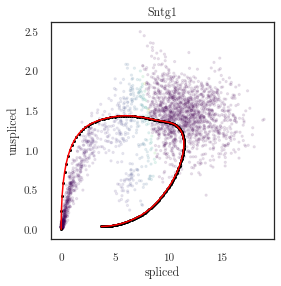

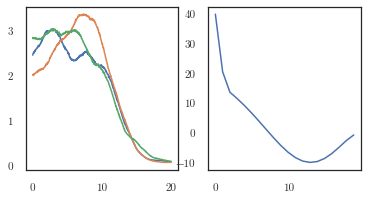

In [10]:
with torch.no_grad():
    lfm.raw_decay_rate += 0
    lfm.raw_transcription_rate -= 0
    lfm.raw_splicing_rate += 0
    pass
print(lfm.transcription_rate.item(), lfm.splicing_rate.item(), lfm.decay_rate.item())
t_predict = lfm.timepoint_choices
out = lfm(t_predict, step_size=step_size)
t = inducing_points
t_f = torch.arange(t.min(), t.max()+step_size/3, step_size/3)
num_samples = 3
s = lfm.sample_latents(t_f, num_samples)

print_scatter(cells, cpe_index, num_connections=0,
              figsize=(4, 4), time_ass=time_ass)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3))
for i in range(num_latents):
    for sample in range(num_samples):
        axes[0].plot(t_f, s[sample, :, i].detach())
mean = list(lfm.gp_model.variational_parameters())[0]
axes[1].plot(mean.detach()[0])
print(lfm.time_assignments_indices.shape)

In [86]:
u_y = cells[:num_genes]  # (num_genes, num_cells)
print(u_y.shape)
s_y = cells[num_genes:]  # (num_genes, num_cells)
print(s_y.shape)
sorted_t, sorted_ind = lfm.time_assignments_indices.sort()
sorted_t = lfm.timepoint_choices[sorted_t]
u_y = u_y[:, sorted_ind].squeeze()
s_y = s_y[:, sorted_ind].squeeze()

torch.Size([1, 3696, 1])
torch.Size([1, 3696, 1])


In [95]:
import time
t0 = time.time()
print(sorted_t)
u_y_bucketed = list()
for t in lfm.timepoint_choices:
    a = sorted_t == t
    u_y_bucketed.append(u_y[a].mean())
t1 = time.time()
print(t1-t0)
u_y_bucketed = torch.tensor(u_y_bucketed)
# 0.0005

tensor([ 0.0000,  0.0000,  0.0000,  ..., 17.9900, 18.0905, 18.1910])
0.02051091194152832


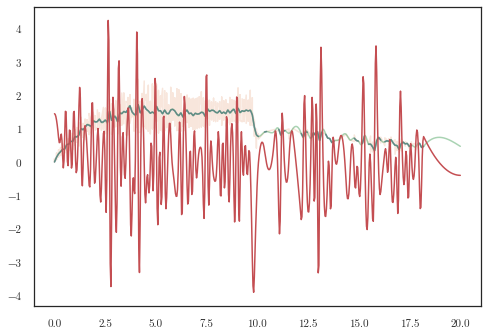

In [106]:
plt.plot(lfm.timepoint_choices, u_y_bucketed)
plt.plot(sorted_t, u_y, alpha=0.2)
from alfi.utilities.torch import spline_interpolate_gradient
t_interpolate, u_y_interp, y_grad, _ = spline_interpolate_gradient(
    lfm.timepoint_choices,
    u_y_bucketed.unsqueeze(-1),
    num_disc=2)
plt.plot(t_interpolate, u_y_interp[:, 0], alpha=0.5)
plt.plot(t_interpolate, y_grad.squeeze())

torch.Size([598])


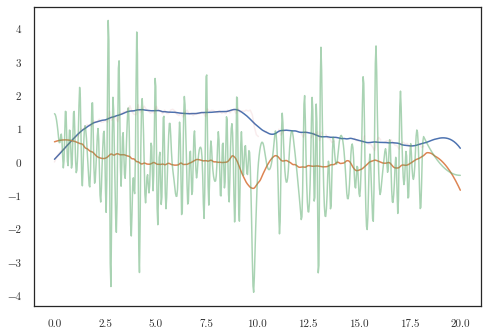

In [123]:
from scipy.signal import savgol_filter
print(t_interpolate.shape)
a = savgol_filter(u_y_interp.squeeze(), window_length=75, polyorder=3)
dt = t_interpolate[1] - t_interpolate[0]
du = savgol_filter(u_y_interp.squeeze(), window_length=75, polyorder=3, deriv=1, delta=dt)
plt.plot(t_interpolate, a)
plt.plot(t_interpolate, du)
plt.plot(t_interpolate, y_grad.squeeze(), alpha=0.5)
plt.plot(lfm.timepoint_choices, u_y_bucketed, alpha=0.1)

torch.Size([3696]) torch.Size([3696])
tensor(181., dtype=torch.float64)
tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], dtype=torch.float64)


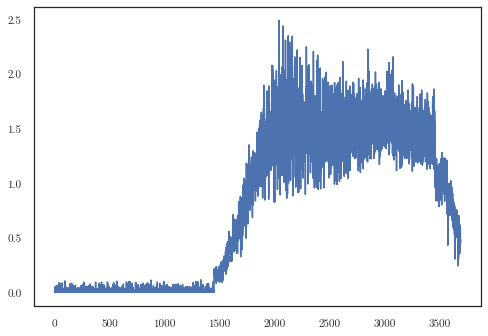

In [ ]:
plt.plot(s_y.squeeze(), u_y.squeeze())

In [10]:
import time
start = time.time()

output = trainer.train(20, report_interval=5, step_size=1e-1, warmup=40)
end = time.time()
print(end - start)

num t2: torch.Size([155])
Epoch 001/020 - Loss: 3.81 (3.75 0.06) kernel: [7.5746446]
num t2: torch.Size([161])
num t2: torch.Size([156])
num t2: torch.Size([155])
num t2: torch.Size([161])
num t2: torch.Size([168])
Epoch 006/020 - Loss: 3.71 (3.64 0.06) kernel: [7.6239233]
num t2: torch.Size([163])
num t2: torch.Size([168])
num t2: torch.Size([163])
num t2: torch.Size([169])
num t2: torch.Size([169])
Epoch 011/020 - Loss: 3.65 (3.59 0.06) kernel: [7.6713305]
num t2: torch.Size([170])
num t2: torch.Size([167])
num t2: torch.Size([174])
num t2: torch.Size([179])
num t2: torch.Size([174])
Epoch 016/020 - Loss: 3.47 (3.40 0.06) kernel: [7.7158656]
num t2: torch.Size([177])
num t2: torch.Size([176])
num t2: torch.Size([177])
num t2: torch.Size([176])
9.951006889343262


y torch.Size([2, 3696, 1])
torch.Size([1, 200])
3.830228939683937 0.062093887478113174


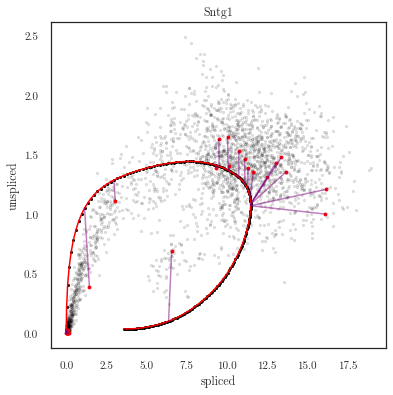

In [15]:
# plotter.plot_outputs(t_predict, replicate=0, t_scatter=t_observed,y_scatter=dataset.m_observed, model_kwargs=model_kwargs);
# plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=True, plot_inducing=False)
# t_predict = torch.linspace(0, 35, 100)
t_predict = lfm.timepoint_choices
y = next(iter(trainer.data_loader)).permute(0, 2, 1)
print('y', y[:-1].shape)
trainer.e_step(y[:-1])
out = lfm(t_predict, step_size=step_size)
end_index = 0 if single_gene else 2
for i in [cpe_index] + list(range(0, end_index)):
    print_scatter(cells, i, num_connections=30, figsize=(6, 6))

log_likelihood, kl_divergence, _ = lfm.loss_fn(out, data.squeeze().t(), mask=trainer.train_mask)
total_loss = (-log_likelihood + kl_divergence)
print(-log_likelihood.item(), kl_divergence.item())
# plotter.plot_losses(trainer, last_x=200)
# 9 5.7

In [ ]:
with torch.no_grad():
    # lfm.raw_decay_rate += 0.5
    # lfm.raw_transcription_rate += 0.5
    lfm.raw_splicing_rate += 0.5

In [ ]:
print(y_target.shape)
plt.scatter(out.mean[:, 1].detach(), out.mean[:, 0].detach())
plt.scatter(y_target[1], y_target[0])

(3, 41)
[0.16119751 0.18814072 0.18729423 0.18644847 0.18561369 0.18477713
 0.18396038 0.18313958 0.18231703 0.18149266 0.1806769  0.1798646
 0.17905866 0.17826396 0.17748429 0.17670228 0.17593816 0.17517957
 0.1744443  0.173737   0.17302606 0.1723248  0.17162609 0.1709554
 0.17030555 0.16965796 0.16904046 0.16841805 0.1678173  0.16721685
 0.16661206 0.16602252 0.16543236 0.16486004 0.16430068 0.16375957
 0.16320527 0.16268553 0.16218454 0.16167654 0.16119751]


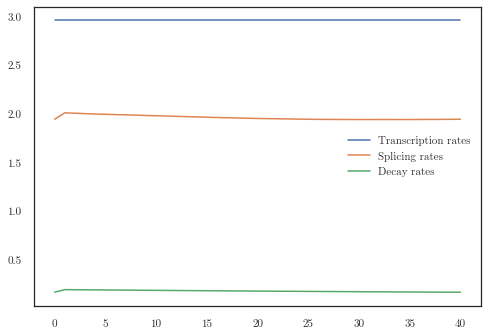

In [36]:
titles = ['Transcription rates', 'Splicing rates', 'Decay rates']
kinetics = list()
for key in track_parameters:
    param = trainer.parameter_trace[key]
    param = torch.tensor(param)
    kinetics.append(
        lfm.positivity.transform(param).numpy())
kinetics = np.array(kinetics)
print(kinetics.shape)
for i in range(3):
    plt.plot(kinetics[i], label=titles[i])
plt.legend()
print(kinetics[2])

In [ ]:
savefile = './rna-1106'
do_save = False
if do_save:
    lfm.save(savefile)

do_load = False
if do_load:
    lfm = RNAVelocityLFM.load(savefile,
                              gp_model=gp_model,
                              lfm_args=[lfm.num_outputs, config],
                              lfm_kwargs=lfm_kwargs)


    optimizer = torch.optim.Adam(lfm.parameters(), lr=0.1)
    trainer = EMTrainer(lfm, [optimizer], dataset, batch_size=4000)
print(do_load)

In [ ]:
#0, -3 15
#0 -2 0 3
out = lfm(lfm.timepoint_choices, step_size=step_size)
print(out.mean.shape)
out = out.mean.t().detach()
u_out = out[:num_genes].squeeze()
s_out = out[num_genes:].squeeze()
plt.plot(u_out[cpe_index, ::10])
plt.plot(-s_out[cpe_index, ::10] + 0.38)
# plt.plot(s_out[cpe_index, ::10], u_out[cpe_index, ::10])
# plt.plot(s_out[cpe_index, ::10])

In [ ]:
print(lfm.time_assignments_indices.max())
u_out = lfm.current_trajectory[:num_genes].detach()
s_out = lfm.current_trajectory[num_genes:].detach()
plt.plot(u_out[cpe_index])
plt.plot(-s_out[cpe_index] + 0.38)

In [ ]:
plt.plot(u_y[cpe_index, ::100])
plt.plot(-s_y[cpe_index, ::100])

# plt.scatter(s_y[cpe_index, ::10], u_y[cpe_index, ::10], alpha=0.1,s=5, c='black')

In [ ]:
out = lfm(lfm.timepoint_choices, step_size=step_size)

In [ ]:
mean = out.mean.t()
print(cells.shape, mean.shape)
# print(cells.squeeze()[0])
# print(cells.squeeze()[2000])
# print((cells.squeeze() * nonzero_mask)[2000].nonzero())
# with torch.no_grad():
    # lfm.splicing_rate[cpe_index] += 0.2
    # lfm.raw_decay_rate[cpe_index] += 0.5
print(lfm.decay_rate[cpe_index])
print(lfm.splicing_rate[cpe_index])
print(lfm.transcription_rate[cpe_index])
print(dict(gp_model.named_variational_parameters()))

In [ ]:
print(l2[cpe_index])
print(gamma.shape)
print(gamma.min())
print(gamma.max())
# s_low = s_y[s_sort_ind[-50:]]
# print(s_low)
# u_y.shape, s_y.shape

In [ ]:
print(y_target.shape)
print(lfm.current_trajectory.shape)
u = lfm.current_trajectory[:2000].detach()[cpe_index]
s = lfm.current_trajectory[2000:].detach()[cpe_index]
u_y = y_target[:2000]  # (num_genes, num_cells)
s_y = y_target[2000:]  # (num_genes, num_cells)
print(u.shape, u_y.shape)
plt.scatter(s, u)
plt.scatter(s_y[cpe_index], u_y[cpe_index])

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(5, 2))
axes[0].plot(u[:, cpe_index])
axes[1].plot(s[:, cpe_index])

### Outputs after training

In [ ]:
plotter.plot_losses(trainer, last_x=100)

for i in range(0, 50, 2):
    print_scatter(cells, i, num_connections=0)


In [ ]:
from alfi.utilities.torch import ceil
for i, data in enumerate(trainer.data_loader):
    y = data.permute(0, 2, 1)  # (O, C, 1)
batch_size = 500
num_batches = ceil(y.shape[1] / batch_size)
u_y = y[:num_outputs//2]  # (num_genes, num_cells)
s_y = y[num_outputs//2:]  # (num_genes, num_cells)
plt.scatter(s_y[cpe_index, :, 0], u_y[cpe_index, :, 0])
plt.scatter(s[cpe_index, :, 0], u[cpe_index, :, 0])
print(u_y.shape, s.shape)
print(num_batches * 500)
time_ass = torch.clone(lfm.time_assignments_indices)
for batch in range(num_batches):
    from_index = batch * batch_size
    to_index = (batch+1) * batch_size
    u_residual = u_y[:, from_index:to_index] - u.transpose(1, 2)
    s_residual = s_y[:, from_index:to_index] - s.transpose(1, 2)

    residual = u_residual.square() + s_residual.square()
    residual = residual.sum(dim=0).argmin(dim=1).type(torch.long)
    # print(residual.shape)
    # print(residual[:5])
    # print('done', batch)
    time_ass[from_index:to_index] = residual

In [ ]:
data = next(iter(trainer.data_loader))
y = data.permute(0, 2, 1)  # (O, C, 1)
print(y.shape)

traj = lfm.current_trajectory
u = traj[:2000].detach().unsqueeze(2)  # (num_genes, 100, 1)
s = traj[2000:].detach().unsqueeze(2)  # (num_genes, 100, 1)
u_y = y[:2000]  # (num_genes, num_cells)
s_y = y[2000:]  # (num_genes, num_cells)
u_y = cells[:2000]  # (num_genes, num_cells)
s_y = cells[2000:]  # (num_genes, num_cells)
print(s_y.shape, s.transpose(1, 2).shape)
u_residual = u_y[1500:] - u[1500:].transpose(1, 2)
s_residual = s_y[1500:] - s[1500:].transpose(1, 2)
print(u_residual.shape) # (genes, cells, timepoints)
residual = u_residual.square() + s_residual.square()
residual_indices = residual.sum(dim=0).argmin(dim=1).type(torch.long)
gene_index = cpe_index
print(gene_index)
print(residual.shape)
# residual_indices = residual.argmin(dim=1)
print(residual_indices.shape)
residual_minimum = residual.min(dim=1).values
print('min', residual_minimum.shape)
residual_sort_indices = residual_minimum.argsort(descending=True)
# print(residual_sort_indices)
# for this gene, the indices of the closest timepoint for all cells

# Plot trajectory
plt.scatter(s[gene_index], u[gene_index])

# Plot cell points
indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                         u_y[gene_index, :, 0].nonzero())
plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], s=6, c='black')
print()#torch.cat([
# for cell_index in residual_sort_indices[-900:]:#, residual_indices[torch.randperm(residual_indices.shape[0])[:1]]]):
for cell_index in range(10):
    plt.scatter(s_y[gene_index, cell_index, 0], u_y[gene_index, cell_index, 0], s=2, c='red')
    line = [
    (s[gene_index, residual_indices[cell_index]], s_y[gene_index, cell_index, 0]),
    (u[gene_index, residual_indices[cell_index]], u_y[gene_index, cell_index, 0])
    ]
    plt.plot(line[0], line[1], alpha=0.4, c='purple')

    line = [
        (s[gene_index, time_ass[cell_index]], s_y[gene_index, i, 0]),
        (u[gene_index, time_ass[cell_index]], u_y[gene_index, i, 0])
    ]
    plt.plot(line[0], line[1], alpha=0.5, c='red')

# plt.xlim(0.015, 0.071)
# plt.ylim(0.22, 0.25)

In [ ]:
t
import scvelo as scv
scv.tl.velocity(dataset.loom)

In [ ]:
scv.pl.velocity(dataset.loom, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

In [ ]:
velocity = dataset.loom.layers['velocity']
print(velocity[:100, cpe_index].shape)

In [ ]:
adata = dataset.loom
_layers = adata[:, cpe_index].layers
u = _layers['Mu']
s = _layers['Ms']
